In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import os
import matplotlib as mpl
from PIL import Image
from palettable.cmocean.sequential import Deep_20
deep = mcolors.ListedColormap(Deep_20.mpl_colors)
import glob
from matplotlib import colors
from matplotlib.colors import LogNorm
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.colors import TwoSlopeNorm
# from matplotlib.colors import DivergingNorm
import h5py
from matplotlib.lines import Line2D

/home/cneumaie/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:

style = "/home/cneumaie/Scripts/Styles/christine-paperlight.mpstyle"

plt.style.use(style)
###Figure Settings
# -- Axes --
from matplotlib.pyplot import rcParams

plt.rcParams['font.size'] = 29


Duplicate key in file '/home/cneumaie/Scripts/Styles/christine-paperlight.mpstyle', line 15 ("xtick.color: 'k'")
Duplicate key in file '/home/cneumaie/Scripts/Styles/christine-paperlight.mpstyle', line 16 ("ytick.color: 'k'")
Duplicate key in file '/home/cneumaie/Scripts/Styles/christine-paperlight.mpstyle', line 27 ('axes.edgecolor:222222')


In [3]:
savePath = "./CPTrain_Figs/"

In [4]:
def get_depth_extra(depth_array):
    '''creates a new colomn for the equivalent CP1 depth calculation'''
    temp_list = [5,10,20]
    time_list = [30,60,90, 120]
    wind_list = ['shear', 'u0']
    depth_array_2 = np.zeros((len(wind_list),len(temp_list),len(temp_list),len(time_list), 3,50))
    depth_array_2[:,:,:,:,:-1] = np.copy(depth_array)
    for w,wind in enumerate(wind_list):
            for c,CP1_temp in enumerate(temp_list):
                for k,CP2_temp in enumerate(temp_list):
                    for t,time in enumerate(time_list):
                            depth_array_2[w,c,k,t,2,:] = np.copy(depth_array[w,k,k,-1,0])  ### Setting CP1 depth to be the CP1 depth of the same strength as CP2
    return depth_array_2

In [5]:
def load_depth_array(filePath, mode = 0):
    '''loads depth array as an xarray from a file'''
    if mode ==0:
        temp_xr = xr.open_dataset(filePath)
        depth_array = temp_xr["__xarray_dataarray_variable__"].as_numpy()
    elif mode ==1:
        depth_file = h5py.File(filePath)
        depth_array = np.array(depth_file["depths"])
        depth_file.close()
        
    depth_array2 = get_depth_extra(depth_array)
    
    return depth_array2

In [6]:
def depths_sorted(depth_array, mode = "NoWind"):
    '''calculates the relative differences of the mean edge depths between cp2 and the same relative cp1
        for each cp2 case within each wind profile'''
    data_array2 = np.nanmean(depth_array[:,:,:,:,:,1:11], axis = 5)
    if mode =="NoWind":
        plotted_20k = np.transpose((data_array2[1,:,2,:,1,]-data_array2[1,:,2,:,2,])/data_array2[1,:,2,:,2,])*100
        cp1_20k = round(data_array2[1,2,2,-1,2,],2)
        plotted_10k = np.transpose((data_array2[1,:,1,:,1,]-data_array2[1,:,1,:,2,])/data_array2[1,:,1,:,2,])*100
        cp1_10k = round(data_array2[1,1,1,-1,2,],2)
        plotted_5k = np.transpose((data_array2[1,:,0,:,1,]-data_array2[1,:,0,:,2,])/data_array2[1,:,0,:,2,])*100
        cp1_5k = round(data_array2[1,0,0,-1,2,],2)
    elif mode =="Shear":
        plotted_20k = np.transpose((data_array2[0,:,2,:,1,]-data_array2[0,:,2,:,2,])/data_array2[0,:,2,:,2,])*100
        cp1_20k = round(data_array2[0,2,2,-1,2,],2)
        plotted_10k = np.transpose((data_array2[0,:,1,:,1,]-data_array2[0,:,1,:,2,])/data_array2[0,:,1,:,2,])*100
        cp1_10k = round(data_array2[0,2,1,-1,2,],2)        
        plotted_5k = np.transpose((data_array2[0,:,0,:,1,]-data_array2[0,:,0,:,2,])/data_array2[0,:,0,:,2,])*100
        cp1_5k = round(data_array2[0,0,0,-1,2,],2)
    return plotted_5k, plotted_10k, plotted_20k  

def make_filter(depths_06,depths_08, depths_1):
    '''makes a mask for depths filter based on if the results are within a consistency threshold 
        of relative differences'''
    mask = np.zeros((4,3))
    mask[:,:] = np.nan
    for j in range(4):
        for i in range(3):
            temp_06 = depths_06[j,i]
            temp_08 = depths_08[j,i]
            temp_1 = depths_1[j,i]
            temp_all = np.array((temp_06, temp_08, temp_1))
            temp_min = np.min(temp_all)
            temp_max = np.max(temp_all)
            if len(np.unique(np.sign(temp_all))) == 2 or temp_max-temp_min > 15 or np.isnan(temp_all).any():
                
                mask[j,i] = np.nan
            else:
                mask[j,i] = 1
    return mask
def depths_filter(depths_array_06, depths_array_08, depths_array_1, mode="NoWind"):
    '''creates an array that judges depth based on consistency of using different thv thresholds
        for each sorted array created in depths_sorted'''
    depths_06_5k, depths_06_10k, depths_06_20k = depths_sorted(depths_array_06,mode)
    depths_08_5k, depths_08_10k, depths_08_20k = depths_sorted(depths_array_08,mode)
    depths_1_5k, depths_1_10k, depths_1_20k = depths_sorted(depths_array_1,mode)
    mask_5k = make_filter(depths_06_5k, depths_08_5k, depths_1_5k)
    mask_10k = make_filter(depths_06_10k, depths_08_10k, depths_1_10k)
    mask_20k = make_filter(depths_06_20k, depths_08_20k, depths_1_20k)
    return mask_5k, mask_10k, mask_20k

In [7]:
def plot_cp2depths_diffs(data_array, mask_5k, mask_10k, mask_20k, thv_thresh,q, axes,mode = "NOWIND", mode2 = "mean"):
    '''Plots Figure 4a-c (if mode == "NoShear") or 4d-f (if mode =="Shear")
        thv_thresh is the virtual potential temperature deficit threshold used to define the 
        edge of each cold pool
        q is the quantile of depths used to define the maximum edge of the cold pool
    '''
    data_array2 = np.nanmean(data_array[:,:,:,:,:,1:11], axis = 5)
    # fig, axes= plt.subplots(1,3,figsize = (28,14), constrained_layout = True)

    if mode =="NOWIND":
        plotted_20k = np.transpose((data_array2[1,:,2,:,1,]-data_array2[1,:,2,:,2,])/data_array2[1,:,2,:,2,])*100
        cp1_20k = round(data_array2[1,2,2,-1,2,],1)
        plotted_10k = np.transpose((data_array2[1,:,1,:,1,]-data_array2[1,:,1,:,2,])/data_array2[1,:,1,:,2,])*100
        cp1_10k = round(data_array2[1,1,1,-1,2,],1)
        plotted_5k = np.transpose((data_array2[1,:,0,:,1,]-data_array2[1,:,0,:,2,])/data_array2[1,:,0,:,2,])*100
        cp1_5k = round(data_array2[1,0,0,-1,2,],1)
        label1 = "g)"
        label2 = "h)"
        label3 = "i)"
        ax1 = axes[0][0]
        ax2 = axes[0][1]
        ax3 = axes[0][2]
        save_prefix = "4a-c"
    elif mode =="SHEAR":
        plotted_20k = np.transpose((data_array2[0,:,2,:,1,]-data_array2[0,:,2,:,2,])/data_array2[0,:,2,:,2,])*100
        cp1_20k = round(data_array2[0,2,2,-1,2,],1)
        plotted_10k = np.transpose((data_array2[0,:,1,:,1,]-data_array2[0,:,1,:,2,])/data_array2[0,:,1,:,2,])*100
        cp1_10k = round(data_array2[0,2,1,-1,2,],1)        
        plotted_5k = np.transpose((data_array2[0,:,0,:,1,]-data_array2[0,:,0,:,2,])/data_array2[0,:,0,:,2,])*100
        cp1_5k = round(data_array2[0,0,0,-1,2,],1)
        label1 = "j)"
        label2 = "k)"
        label3 = "l)"
        ax1 = axes[1][0]
        ax2 = axes[1][1]
        ax3 = axes[1][2]
        save_prefix ="4d-f"
    print(f" thv thresh {-round(thv_thresh,2):03} K,upper quantile {q} {mode}")
    cmap = "RdBu_r"
    norm = TwoSlopeNorm(vmin = -50, vcenter = 0, vmax = 50)
    df = pd.DataFrame(plotted_5k)

    # Replace NaNs with 'N/A'
    df.fillna('N/A', inplace=True)

    # Convert back to a NumPy array (if needed)
    plotted_5k_label = df.values
    
    c = ax1.imshow(plotted_5k, cmap = cmap, norm = norm)
    ax1.set_yticks(ticks = np.arange(4),labels =[30,60,90,120])
    if mode == "SHEAR":
        ax1.set_xticks(ticks = np.arange(3),labels = [-5,-10,-20])
    else:
        ax1.set_xticks(ticks = np.arange(3),labels = ['']*3)
    for j in range(4):
        for i in range(3):
            if np.abs(plotted_5k[j,i]) >30:
                      color = "white"
            else:
                      color = "k"
            if mask_5k[j,i] ==1:
                weight = "bold"
            else:
                weight = "normal"
            if type(plotted_5k_label[j,i]) != str:
                ax1.text(i,j,"{:.1f}".format(plotted_5k_label[j,i]),
                         horizontalalignment='center',verticalalignment='center',
                         color=color, weight=weight)
            else:
                ax1.text(i,j,"{:}".format(plotted_5k_label[j,i]),
                         horizontalalignment='center',verticalalignment='center',
                         color=color, weight=weight)
    # if mode =="SHEAR":
    #     ax1.set_xlabel("CP1 Temperature (K)")
    ax1.set_ylabel("Time between CPs (min)")
    ax1.set_title(f"CP2 -5K \n CP1={cp1_5k} m", fontsize = 31)
    ax1.text(-.06, 1.2, label1, ha='left', va='top', weight = 'bold', size = 31, transform=ax1.transAxes)
    
    df = pd.DataFrame(plotted_10k)

    # Replace NaNs with 'N/A'
    df.fillna('N/A', inplace=True)

    # Convert back to a NumPy array (if needed)
    plotted_10k_label = df.values

    c = ax2.imshow(plotted_10k, cmap = cmap, norm = norm)
    ax2.set_yticks(ticks = np.arange(4))
    ax2.set_yticklabels(['']*4)
    if mode == "SHEAR":
        ax2.set_xticks(ticks = np.arange(3),labels = [-5,-10,-20])
    else:
        ax2.set_xticks(ticks = np.arange(3),labels = ['']*3)
    for j in range(4):
        for i in range(3):
            if np.abs(plotted_10k[j,i]) >30:
                      color = "white"
            else:
                      color = "k"
            if mask_10k[j,i] ==1:
                weight = "bold"
            else:
                weight = "normal"
            if type(plotted_10k_label[j,i]) != str:
                ax2.text(i,j,"{:.1f}".format(plotted_10k_label[j,i]),
                         horizontalalignment='center',verticalalignment='center',
                         color=color,weight=weight)
            else:
                ax2.text(i,j,"{:}".format(plotted_10k_label[j,i]),
                         horizontalalignment='center',verticalalignment='center',
                         color=color,weight=weight)
    if mode =="SHEAR":
        ax2.set_xlabel("CP1 Temperature (K)", fontsize = 35)
    ax2.set_title(f"CP2 -10K  \n CP1={cp1_10k} m", fontsize = 31)
    ax2.text(-0.06, 1.2, label2, ha='left', va='top', weight = 'bold', size = 31, transform=ax2.transAxes)
    # ax2.text(0.4, 1.32,mode,ha='center', va='top', weight = 'bold', size = 38, transform = ax2.transAxes)
    ax1.text(
    x=-0.5,  # Slightly outside the left axis (negative x-value)
    y=0.5,   # Middle of the y-axis
    s='     ',  # The text content
    rotation=90,  # Rotate the text 90 degrees
    verticalalignment='center',  # Centered vertically
    horizontalalignment='center',  # Centered horizontally
    fontsize=35,  # Set the font size
    weight = "bold",
    transform=ax1.transAxes  # Use axis coordinates for positioning
    )
    df = pd.DataFrame(plotted_20k)
    
    # Replace NaNs with 'N/A'
    df.fillna('N/A', inplace=True)

    # Convert back to a NumPy array (if needed)
    plotted_20k_label = df.values
    
    c = ax3.imshow(plotted_20k, cmap = cmap, norm = norm)
    
    ax3.set_yticks(ticks = np.arange(4))
    ax3.set_yticklabels(['']*4)
    if mode == "SHEAR":
        ax3.set_xticks(ticks = np.arange(3),labels = [-5,-10,-20])
    else:
        ax3.set_xticks(ticks = np.arange(3),labels = ['']*3)
    for j in range(4):
        for i in range(3):
            if np.abs(plotted_20k[j,i]) >30:
                      color = "white"
            else:
                      color = "k"
            if mask_20k[j,i] ==1:
                weight = "bold"
            else:
                weight = "normal"
            if type(plotted_20k_label[j,i]) != str:
                ax3.text(i,j,"{:.1f}".format(plotted_20k_label[j,i]),
                         horizontalalignment='center',verticalalignment='center',
                         color=color,weight=weight)
            else:
                ax3.text(i,j,"{:}".format(plotted_20k_label[j,i]),
                         horizontalalignment='center',verticalalignment='center',
                         color=color,weight=weight)
    # if mode =="SHEAR":
    #     ax3.set_xlabel("CP1 Temperature (K)")
    ax3.set_title(f"CP2 -20K \n CP1={cp1_20k} m", fontsize  = 31)
    ax3.text(-.06, 1.2, label3, ha='left', va='top', weight = 'bold', size = 31, transform=ax3.transAxes)

    return c

In [8]:
thv_thresholds = np.arange(0.6,1.1,0.2)  ## 0.8K thv deficit used for figure 4, 0.6 and 1 K used for significance testing
# thv_thresholds = np.arange(0.8,1,0.2) ## 
q = 95 # quantile of depths used to define the maximum edge of the cold pool
filepath_list = [f"/home/cneumaie/Scripts/cpdepths_test_files_time_v11_95/thv{round(thv,2):03}_q{q}.h5" for thv in thv_thresholds]
depth_array_list = [load_depth_array(filePath, mode =1) for filePath in filepath_list]  ###load the edge depths arrays to make significance masls
mask_5k_u0, mask_10k_u0, mask_20k_u0 = depths_filter(depth_array_list[0], depth_array_list[1], ## make the masks for the NoShear cases
                                                     depth_array_list[2], mode = "NoWind")
        

/tmp/ipykernel_1177737/2720596819.py:4: RuntimeWarning: Mean of empty slice
  data_array2 = np.nanmean(depth_array[:,:,:,:,:,1:11], axis = 5)


In [9]:
###this version of the plotting function is for the supplementary figure 3 (S3)
def plot_cp2depths_diffs_supp(data_array, mask_5k, mask_10k, mask_20k, thv_thresh,q,axes, mode = "NOWIND", mode2 = "mean"):
    '''Plots Figure 4a-c (if mode == "NoShear") or 4d-f (if mode =="Shear")
        thv_thresh is the virtual potential temperature deficit threshold used to define the 
        edge of each cold pool
        q is the quantile of depths used to define the maximum edge of the cold pool
    '''
    data_array2 = np.nanmean(data_array[:,:,:,:,:,1:11], axis = 5)
    # fig, axes= plt.subplots(1,3,figsize = (14,14), constrained_layout = True)
    xlabel = False
    ylabel = False
    if mode =="NOWIND":
        plotted_20k = np.transpose((data_array2[1,:,2,:,1,]-data_array2[1,:,2,:,2,])/data_array2[1,:,2,:,2,])*100
        cp1_20k = round(data_array2[1,2,2,-1,2,],2)
        plotted_10k = np.transpose((data_array2[1,:,1,:,1,]-data_array2[1,:,1,:,2,])/data_array2[1,:,1,:,2,])*100
        cp1_10k = round(data_array2[1,1,1,-1,2,],2)
        plotted_5k = np.transpose((data_array2[1,:,0,:,1,]-data_array2[1,:,0,:,2,])/data_array2[1,:,0,:,2,])*100
        cp1_5k = round(data_array2[1,0,0,-1,2,],2)
        label1 = "i."
        label2 = "ii."
        label3 = "iii."
        ylabel = True
        if thv_thresh == 0.6:
            save_prefix = "S1a"
            title_prefix = "a)"
            ax1 = axes[0][0]
            ax2 = axes[0][1]
            ax3 = axes[0][2]
        elif thv_thresh == 0.8:
            save_prefix = "S1c"
            title_prefix = "b)"
            ax1 = axes[1][0]
            ax2 = axes[1][1]
            ax3 = axes[1][2]
        elif thv_thresh == 1:
            save_prefix = "S1e"
            title_prefix = "c)"
            ax1 = axes[2][0]
            ax2 = axes[2][1]
            ax3 = axes[2][2]
            xlabel = True

    print(f" thv thresh {-round(thv_thresh,2):03} K,upper quantile {q} {mode}")
    cmap = "RdBu_r"
    norm = TwoSlopeNorm(vmin = -50, vcenter = 0, vmax = 50)
    df = pd.DataFrame(plotted_5k)

    # Replace NaNs with 'N/A'
    df.fillna('N/A', inplace=True)

    # Convert back to a NumPy array (if needed)
    plotted_5k_label = df.values
    
    c = ax1.imshow(plotted_5k, cmap = cmap, norm = norm)
    ax1.set_yticks(ticks = np.arange(4),labels =[30,60,90,120])
    ax1.set_xticks(ticks = np.arange(3),labels = [-5,-10,-20])
    for j in range(4):
        for i in range(3):
            if np.abs(plotted_5k[j,i]) >30:
                      color = "white"
            else:
                      color = "k"
            if mask_5k[j,i] ==1:
                weight = "bold"
            else:
                weight = "normal"
            if type(plotted_5k_label[j,i]) != str:
                ax1.text(i,j,"{:.1f}".format(plotted_5k_label[j,i]),
                         horizontalalignment='center',verticalalignment='center',
                         color=color, weight=weight)
            else:
                ax1.text(i,j,"{:}".format(plotted_5k_label[j,i]),
                         horizontalalignment='center',verticalalignment='center',
                         color=color, weight=weight)
    if xlabel == True:
        ax1.set_xlabel("CP1 Temperature (K)")
    if ylabel == True:
        ax1.set_ylabel("Time between CPs (min)")
    ax1.set_title(f"CP2 -5K \n CP1={cp1_5k} m")
    ax1.text(-.06, 1.1, label1, ha='left', va='top', weight = 'bold', size = 32, transform=ax1.transAxes)
    ylabel = False
    df = pd.DataFrame(plotted_10k)

    # Replace NaNs with 'N/A'
    df.fillna('N/A', inplace=True)

    # Convert back to a NumPy array (if needed)
    plotted_10k_label = df.values

    c = ax2.imshow(plotted_10k, cmap = cmap, norm = norm)
    ax2.set_yticks(ticks = np.arange(4),labels =[30,60,90,120])
    ax2.set_xticks(ticks = np.arange(3),labels = [-5,-10,-20])
    for j in range(4):
        for i in range(3):
            if np.abs(plotted_10k[j,i]) >30:
                      color = "white"
            else:
                      color = "k"
            if mask_10k[j,i] ==1:
                weight = "bold"
            else:
                weight = "normal"
            if type(plotted_10k_label[j,i]) != str:
                ax2.text(i,j,"{:.1f}".format(plotted_10k_label[j,i]),
                         horizontalalignment='center',verticalalignment='center',
                         color=color,weight=weight)
            else:
                ax2.text(i,j,"{:}".format(plotted_10k_label[j,i]),
                         horizontalalignment='center',verticalalignment='center',
                         color=color,weight=weight)
    
    if xlabel == True:
        ax2.set_xlabel("CP1 Temperature (K)")
    if ylabel == True:
        ax2.set_ylabel("Time between CPs (min)")
    ax2.text(-.06, 1.1, label2, ha='left', va='top', weight = 'bold', size = 32, transform=ax2.transAxes)
    ax2.text(0.5, 1.3,title_prefix+r"$\Theta_v$' threshold = "+str(thv)+" K \n",ha='center', va='top', weight = 'bold', size = 35, transform = ax2.transAxes)
    ax2.set_title(f"CP2 -10K \n CP1={cp1_10k} m")
    # ax2.text(0,1.5,title_prefix+r"$\Theta_v$' threshold = "+str(thv)+"K \n"+ str(mode), fontweight = 'bold', fontsize = 38)
    df = pd.DataFrame(plotted_20k)
    
    # Replace NaNs with 'N/A'
    df.fillna('N/A', inplace=True)

    # Convert back to a NumPy array (if needed)
    plotted_20k_label = df.values
    
    c = ax3.imshow(plotted_20k, cmap = cmap, norm = norm)
    
    # fig.colorbar(c, label = f"Relative Depth Difference (%)", fraction=0.046, pad=0.1)
    ax3.set_yticks(ticks = np.arange(4),labels =[30,60,90,120])
    ax3.set_xticks(ticks = np.arange(3),labels = [-5,-10,-20])
    for j in range(4):
        for i in range(3):
            if np.abs(plotted_20k[j,i]) >30:
                      color = "white"
            else:
                      color = "k"
            if mask_20k[j,i] ==1:
                weight = "bold"
            else:
                weight = "normal"
            if type(plotted_20k_label[j,i]) != str:
                ax3.text(i,j,"{:.1f}".format(plotted_20k_label[j,i]),
                         horizontalalignment='center',verticalalignment='center',
                         color=color,weight=weight)
            else:
                ax3.text(i,j,"{:}".format(plotted_20k_label[j,i]),
                         horizontalalignment='center',verticalalignment='center',
                         color=color,weight=weight)
    
    if xlabel == True:
        ax3.set_xlabel("CP1 Temperature (K)")
    if ylabel == True:
        ax3.set_ylabel("Time between CPs (min)")
    ax3.set_title(f"CP2 -20K \n CP1={cp1_20k} m ")
    ax3.text(-.06, 1.1, label3, ha='left', va='top', weight = 'bold', size = 32, transform=ax3.transAxes)
    # ax2.text(1.3,0,title_prefix+r"$\Theta_v$' threshold = "+str(thv)+"K \n"+ str(mode), fontweight = 'bold', fontsize = 38)


    return c

/tmp/ipykernel_1177737/3496613300.py:8: RuntimeWarning: Mean of empty slice
  data_array2 = np.nanmean(data_array[:,:,:,:,:,1:11], axis = 5)
/tmp/ipykernel_1177737/3496613300.py:8: RuntimeWarning: Mean of empty slice
  data_array2 = np.nanmean(data_array[:,:,:,:,:,1:11], axis = 5)
/tmp/ipykernel_1177737/3496613300.py:8: RuntimeWarning: Mean of empty slice
  data_array2 = np.nanmean(data_array[:,:,:,:,:,1:11], axis = 5)


 thv thresh -0.6 K,upper quantile 95 NOWIND
 thv thresh -0.8 K,upper quantile 95 NOWIND
 thv thresh -1.0 K,upper quantile 95 NOWIND


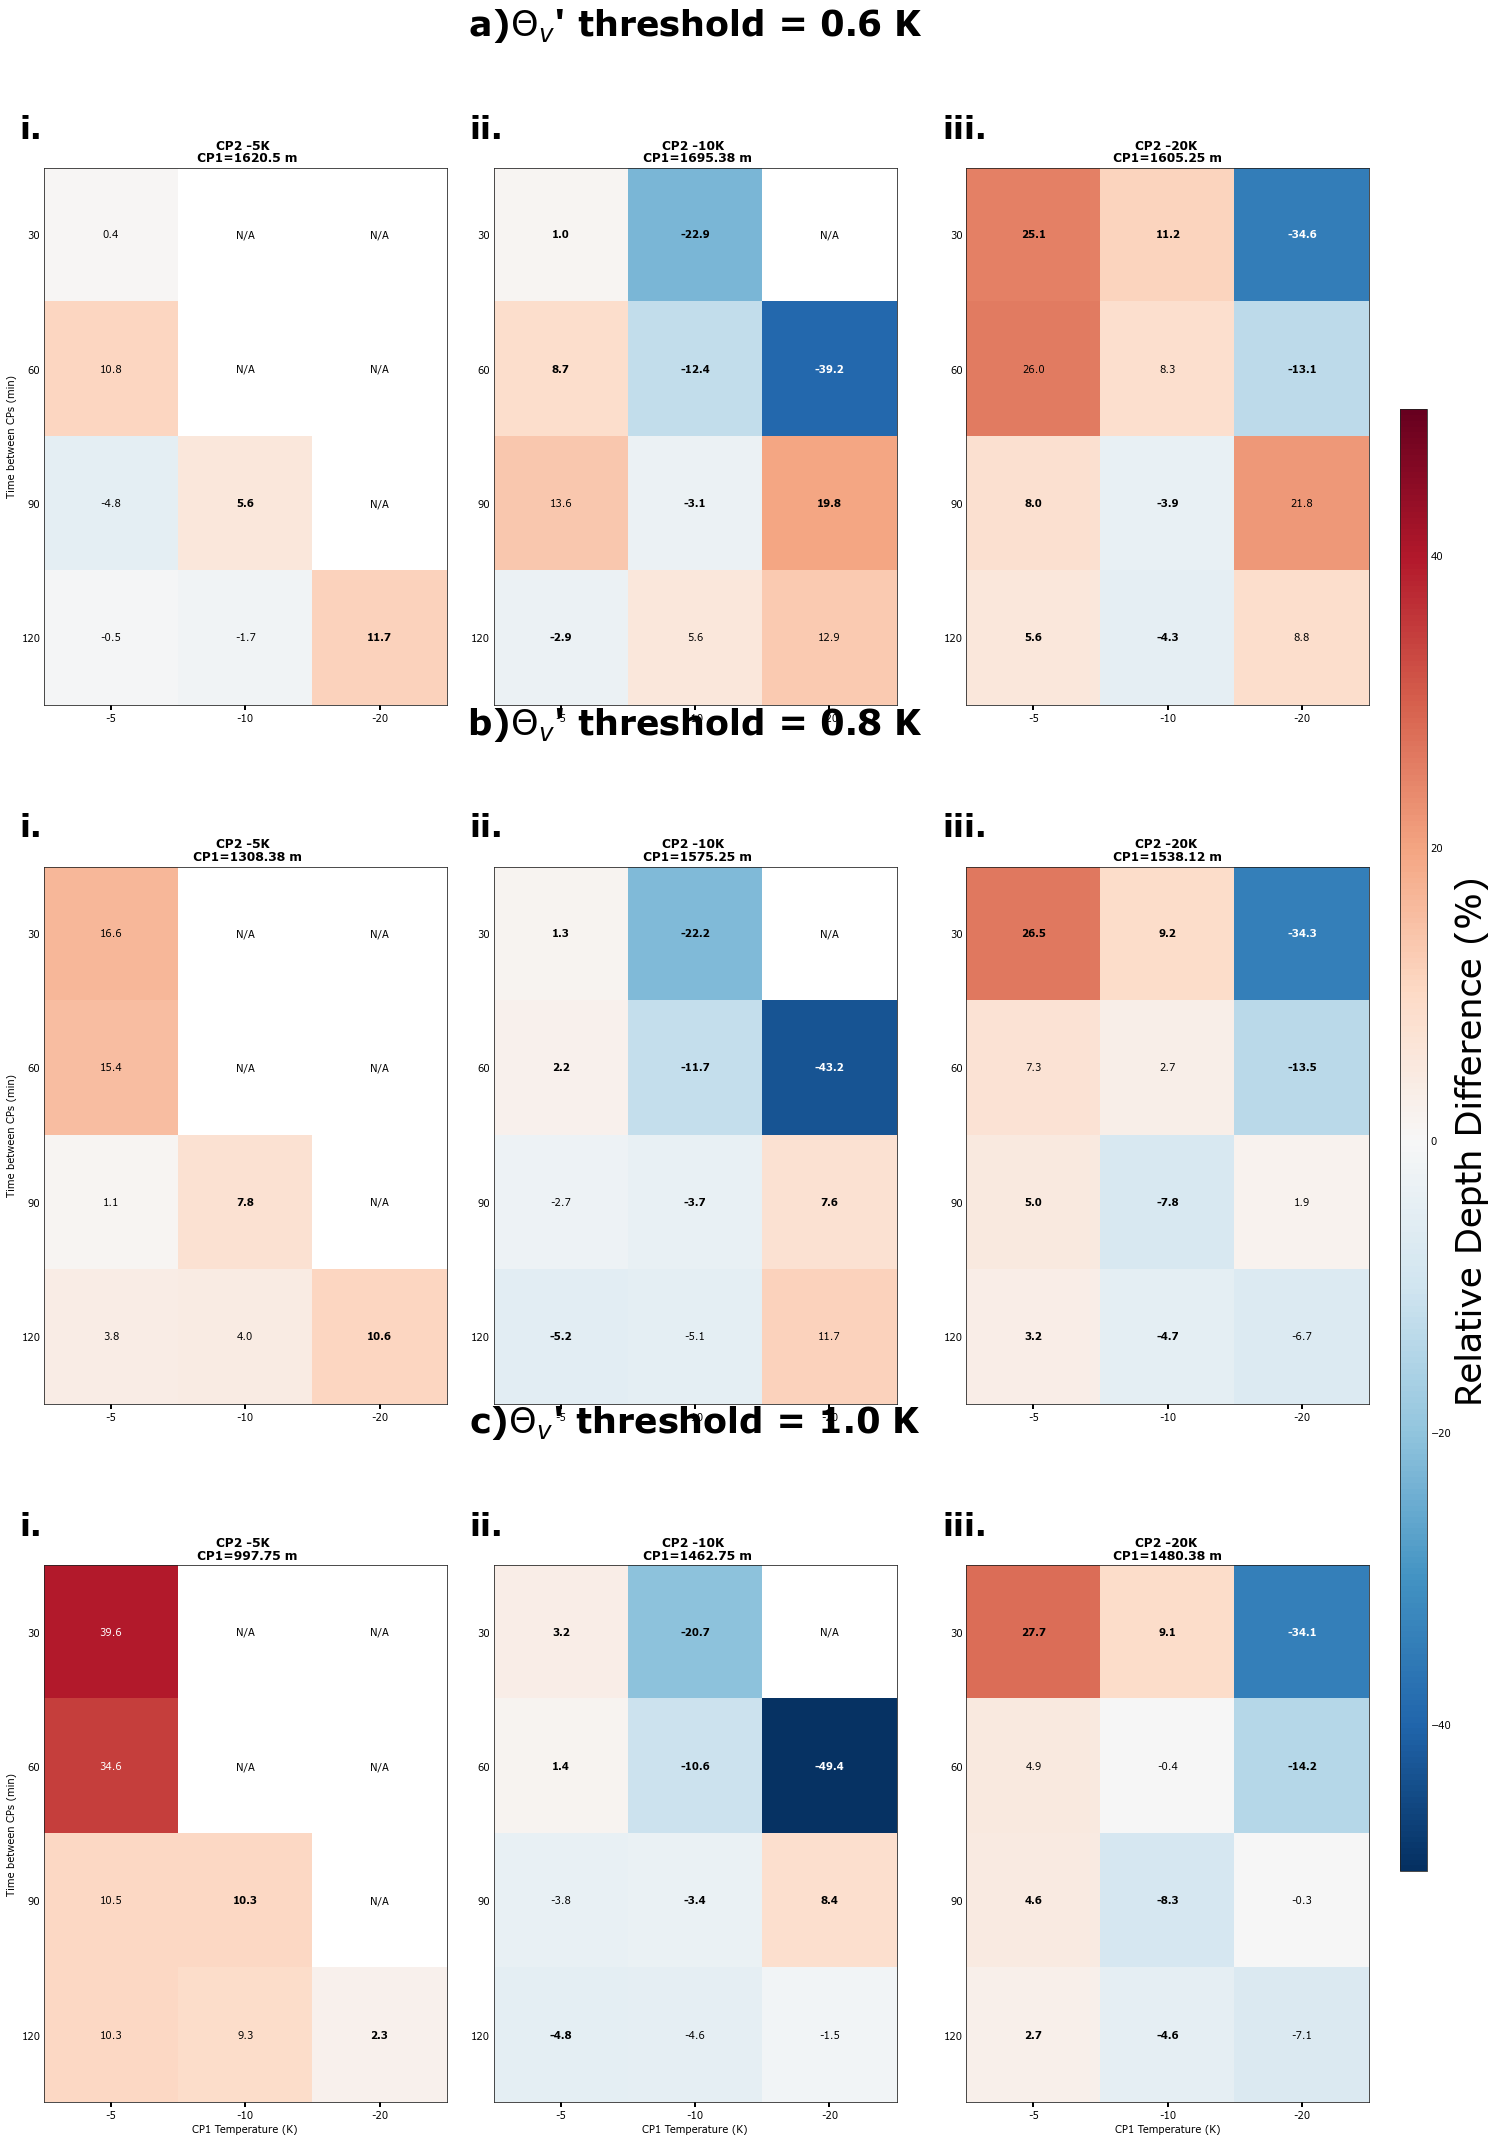

In [10]:
thv_thresholds = np.arange(0.6,1.1,0.2)
fig, axes= plt.subplots(3,3,figsize = (19,29), constrained_layout = True)#, gridspec_kw={

for thv in thv_thresholds:
        filePath = f"/home/cneumaie/Scripts/cpdepths_test_files_time_v11_95/thv{round(thv,2):03}_q{q}.h5"
        depth_array = load_depth_array(filePath, mode =1)

        c = plot_cp2depths_diffs_supp(depth_array,mask_5k_u0, mask_10k_u0, mask_20k_u0,thv,q,axes, mode = "NOWIND") 
cax = fig.add_axes([1.02, 0.12, 0.02, 0.7])
fig.colorbar(c, fraction=0.046, pad=0.1, cax = cax).set_label(label='Relative Depth Difference (%)',size=35)
# plt.savefig(f"{savePath}depth_{q}_{thv}_supp_v6.png")
plt.show()
plt.close()
        
        
        

In [11]:
axes

array([[<Axes: title={'center': 'CP2 -5K \n CP1=1620.5 m'}, ylabel='Time between CPs (min)'>,
        <Axes: title={'center': 'CP2 -10K \n CP1=1695.38 m'}>,
        <Axes: title={'center': 'CP2 -20K \n CP1=1605.25 m '}>],
       [<Axes: title={'center': 'CP2 -5K \n CP1=1308.38 m'}, ylabel='Time between CPs (min)'>,
        <Axes: title={'center': 'CP2 -10K \n CP1=1575.25 m'}>,
        <Axes: title={'center': 'CP2 -20K \n CP1=1538.12 m '}>],
       [<Axes: title={'center': 'CP2 -5K \n CP1=997.75 m'}, xlabel='CP1 Temperature (K)', ylabel='Time between CPs (min)'>,
        <Axes: title={'center': 'CP2 -10K \n CP1=1462.75 m'}, xlabel='CP1 Temperature (K)'>,
        <Axes: title={'center': 'CP2 -20K \n CP1=1480.38 m '}, xlabel='CP1 Temperature (K)'>]],
      dtype=object)